<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC3</p>
<p style="margin: 0; text-align:right;">2020-2 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos como los diferentes modelos clasifican los puntos y con cuales obtenemos mayor precisión. Después aplicaremos todo lo que hemos aprendido hasta ahora a un dataset nuevo simulando un caso práctico real.

1. Exploración de algoritmos supervisados
    1. Naive-Bayes
    2. $k$ vecinos más próximos
    3. Support vector machines
    4. Árboles de decisión
    5. Random forest / Gradient boosting
2. Implementación del caso práctico
    1. Análisis descriptivo
    2. Preprocesamiento de los datos
    3. Entrenamiento del modelo
    4. Predicción de nuevos casos

**Importante: Cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega se hará en formato notebook y en formato html donde se vea el código y los resultados, junto con los comentarios de cada ejercicio. Para exportar el notebook a html se puede hacer desde el menú File $\to$ Download as $\to$ HTML.**

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils import check_random_state
import numpy.random as nr

# Visualizar árboles
from IPython.display import Image
import pydotplus
from six import StringIO

# UMAP para la reducción de dimensionalidad
import umap

# Visualización
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Exploración de algoritmos supervisados (5 puntos)

En la PEC anterior trabajamos con el dataset MNIST, compuesto de miles de dígitos manuscritos del 0 al 9. Donde cada imagen se compone de 784 píxeles (imágenes de 28 x 28). Redujimos a dos dimensiones el dataset utilizando diferentes técnicas de clustering, y vimos que con UMAP conseguíamos separar las clases (dígitos) bastante bien en 2D.

En este primer ejercicio iremos un paso más allá, utilizaremos diferentes métodos supervisados para predecir las diferentes clases. El objetivo será que, dada una imagen nueva, el algoritmo sea capaz de clasificar correctamente el número de la imagen.

Empezamos cargando el dataset y visualizando un ejemplo de cada dígito.

In [2]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation].astype(int)
X = X.reshape((X.shape[0], -1))

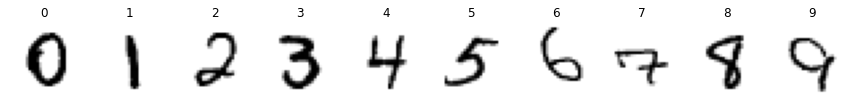

In [3]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in zip(range(10), axis):
    ax.imshow(X[y == i][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

Este dataset es muy grande, con una muestra obtendremos resultados muy similares y nos permitirá trabajar con más agilidad.

In [4]:
all_data = pd.DataFrame(X)
all_data['y'] = y

sample_data = all_data.sample(frac = 0.1, random_state=24)
X = sample_data.drop(columns=['y'])
y = sample_data['y']

print(all_data.shape)
print(sample_data.shape)

(70000, 785)
(7000, 785)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong> 
</div>

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24)

Para poder visualizar los resultados de cada algoritmo supervisado, reduciremos el dataset anterior a dos dimensiones, tal como hicimos en la PEC2.

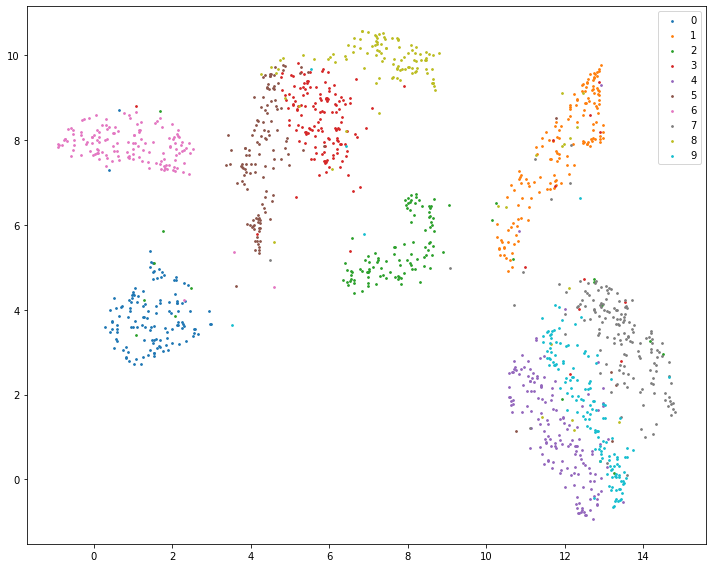

In [6]:
model = umap.UMAP(n_components=2, random_state=42)
model.fit(X_train)
X_train_projection = model.transform(X_train)
X_test_projection = model.transform(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(10):
    ax.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], s=3, label=str(i))
plt.legend()
plt.tight_layout()

A lo largo de los ejercicios aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

   - Crear una _meshgrid_ con los valores mínimo y máximo de 'x' e 'y'.
   - Predecir el clasificador con los valores de la _meshgrid_.
   - Hacer un _reshape_ de los datos para tener el formato correspondiente.
  
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde.

In [7]:
# vamos a crear la meshgrid con los valores mínimos y máximos de los ejes x e y
x_min, x_max = X_test_projection[:, 0].min() - 1, X_test_projection[:, 0].max() + 1
y_min, y_max = X_test_projection[:, 1].min() - 1, X_test_projection[:, 1].max() + 1
    
# definimos la función que visualizará la frontera de decisión
def plot_decision_boundaries(model, X_test_projection, y_test):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    # precedimos con el clasificador con los valores de la meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # definimos los colores (uno para cada clase)
    cmap_light = ListedColormap(['gainsboro','lightgreen','peachpuff','lightcyan', 'pink',
                                 'lightyellow','lavender','lightcoral', 'lightskyblue', 'aquamarine'])
    cmap_bold = ['grey','g','sandybrown','c','palevioletred', 
                 'y','mediumpurple','firebrick', 'dodgerblue', 'mediumaquamarine']
    
    # dibujamos las fronteras
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # dibujamos los puntos
    for i in range(10):
        plt.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], 
                    s=3, label=str(i), c=cmap_bold[i])
    plt.legend()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())    

### 1.1. Gaussian Naïve Bayes

El objetivo de este primer ejercicio es entender el funcionamiento del algoritmo Naïve-Bayes, un algoritmo peculiar ya que se basa completamente en teoría de probabilidades.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> 
</div>

Con el dataset de _train_ reducido a dos dimensiones, entrenad un modelo Naïve-Bayes y representad gráficamente la frontera de decisión con el de _test_. Podéis utilizar el clasificador **GaussianNB** de `sklearn`.
    
Calculad el _accuracy_ del modelo obtenido sobre _train_ y _test_ y la matriz de confusión sobre _test_. Podéis utilizar `accuracy_score` y `confusion_matrix` del paquet `metrics` de `sklearn`.

In [8]:
clf_GNB = GaussianNB()
clf_GNB.fit(X_train_projection, y_train)

GaussianNB()

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


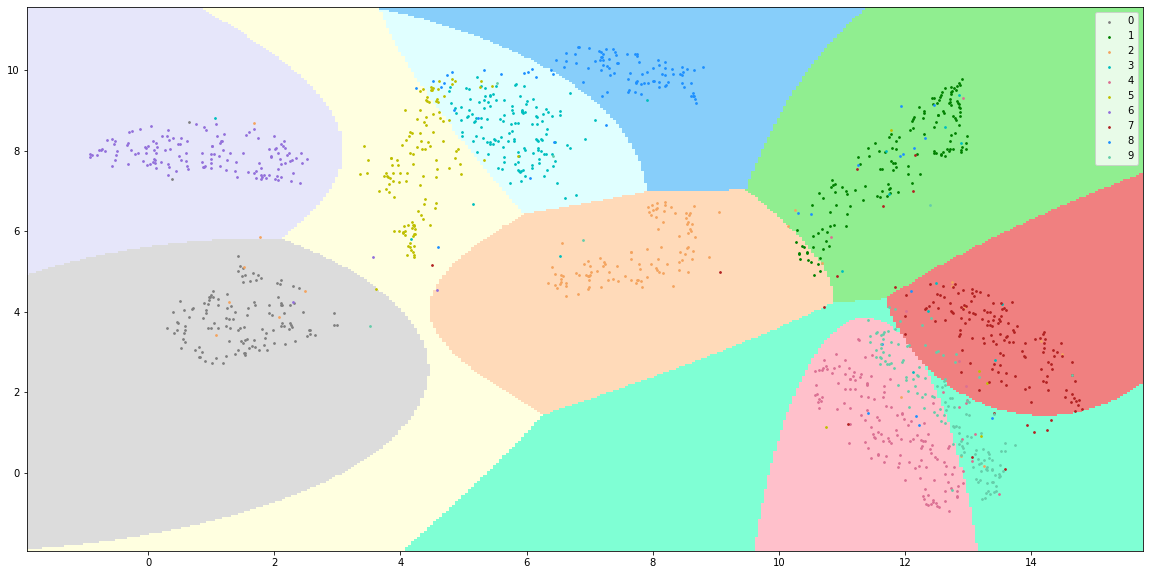

In [9]:
plot_decision_boundaries(clf_GNB, X_test_projection, y_test)

In [10]:
y_pred = clf_GNB.predict(X_test_projection)
accuracy_score(y_test, y_pred)

0.8435714285714285

In [11]:
confusion_matrix(y_test, y_pred)

array([[127,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0, 135,  13,   0,   0,   0,   0,   0,   0,   0],
       [  5,   3, 103,   0,   1,   0,   2,   5,   0,   2],
       [  0,   6,   1, 138,   1,   2,   1,   4,   1,   0],
       [  0,   2,   0,   0, 142,   0,   0,   3,   0,   9],
       [  1,   1,   0,  21,   1, 101,   0,   2,   0,   1],
       [  1,   0,   1,   0,   0,   1, 142,   0,   0,   0],
       [  0,   6,   1,   0,   1,   1,   0, 135,   0,   8],
       [  0,   9,   0,  17,   4,   2,   0,   1,  86,   1],
       [  1,   1,   1,   2,  54,   0,   0,  16,   0,  72]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> 
</div>
  
Análisis del ejercicio.

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?

### 1.2. KNN

El objetivo de este segundo ejercicio es entender el funcionamiento del KNN, intuir sus principales ventajas o desventajas y entender la influencia de los parámetros de los que está compuesto.

K-Nearest-Neighbor es un algoritmo basado en instancia de tipo supervisado. 

Vamos a ver qué significa esto:

  - Supervisado: tenemos etiquetado nuestro conjunto de datos de entrenamiento, con la clase o resultado esperado.
  - Basado en instancia (_Lazy Learning_): Esto significa que nuestro algoritmo no aprende explícitamente un modelo (como por ejemplo en Regresión Logística o árboles de decisión), sino que memoriza las instancias de entrenamiento que son utilizadas como "conocimiento" para la fase de predicción.

¿Cómo funciona KNN?

  - Calculamos la distancia entre el ítem a clasificar y los demás ítems del dataset de entrenamiento.
  - Seleccionamos los "k" elementos más cercanos, es decir, con menor distancia, según la distancia que utilizamos (euclídea, coseno, manhattan, etc).
  - Por último realizamos una "votación de mayoría" entre los k puntos: los de la clase que "dominan" decidirán su clasificación final.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Con el dataset de _train_ reducido a dos dimensiones, entrenad un modelo KNN con `n_neighbors = 2` y representad gráficamente la frontera de decisión con el de _test_.
    
Podéis utilizar el clasificador **KNeighborsClassifier** de `sklearn`.

In [12]:
clf_KNN = KNeighborsClassifier(n_neighbors=2)
clf_KNN.fit(X_train_projection, y_train)

KNeighborsClassifier(n_neighbors=2)

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


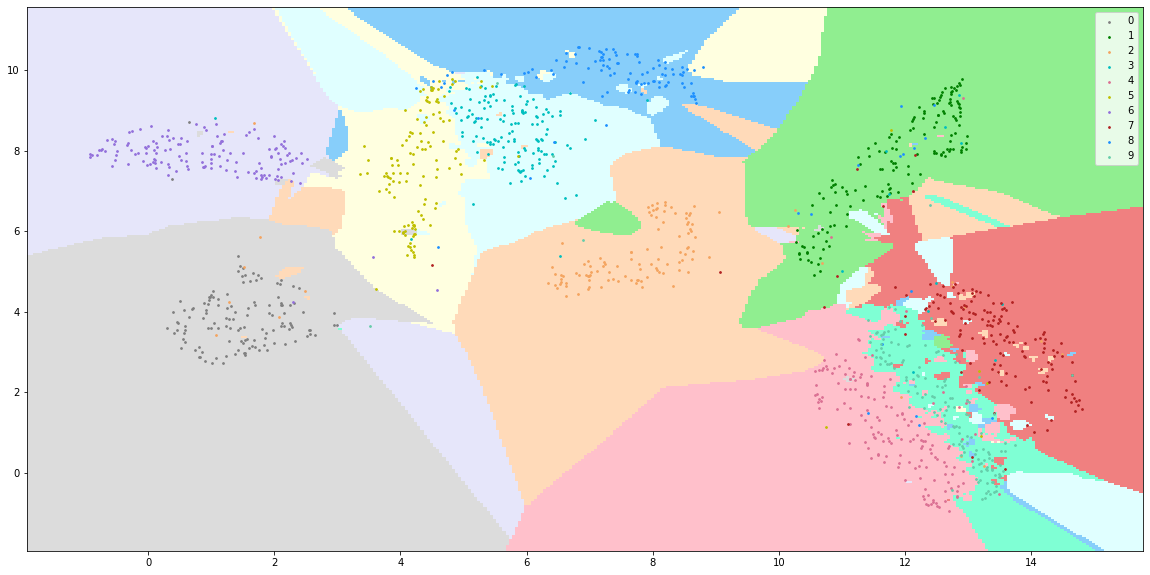

In [13]:
plot_decision_boundaries(clf_KNN, X_test_projection, y_test)

En el modelo entrenado, hemos fijado el parámetro `n_neighbors` de forma arbitraria. Pero podría ser que con otro valor obtuviéramos una mejor predicción.

Para conocer el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_) se suele utilizar una búsqueda de rejilla (_grid search_). Es decir, entrenar un modelo para cada combinación de hiperparámetros posible y evaluarlo utilizando validación cruzada (_cross validation_) con 4 particiones estratificadas. Posteriormente, se elige la combinación de hiperparàmetres que mejores resultados haya obtenido.

En este caso sólo queremos optimizar un hiperparámetro:

   - 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
</div>

Cálculo del valor óptimo del hiperparámetro _k_ (`n_neighbors`). Utilizad una búsqueda de rejilla con validación cruzada para encontrar el valor óptimo de _k_. Por cada valor, calculad su promedio y la desviación estándar. Implementad un _heatmap_ para visualizar la precisión según los diferentes valores del hiperparámetro.
    
Puede utilizar el módulo `GridSearchCV` de `sklearn` el cálculo del mejor hiperparámetro, y `heatmap` de `Seaborn`.

In [14]:
grid_params = {'n_neighbors': list(range(1, 11))}

gs_KNN = GridSearchCV(
        KNeighborsClassifier(),
        grid_params,
        scoring='accuracy',
        n_jobs=-1,
        cv=4
        )
gs_KNN.fit(X_train_projection, y_train)
gs_KNN.best_estimator_

KNeighborsClassifier(n_neighbors=10)

In [15]:
print('Mean test score by n_neighbors')
for i, x in enumerate(gs_KNN.cv_results_['mean_test_score']):
    print('n_neighbors = %2d    %4.3f' % (i+1, x))

Mean test score by n_neighbors
n_neighbors =  1    0.897
n_neighbors =  2    0.901
n_neighbors =  3    0.928
n_neighbors =  4    0.930
n_neighbors =  5    0.931
n_neighbors =  6    0.930
n_neighbors =  7    0.929
n_neighbors =  8    0.931
n_neighbors =  9    0.931
n_neighbors = 10    0.932


In [16]:
print('Std test score by n_neighbors')
for i, x in enumerate(gs_KNN.cv_results_['std_test_score']):
    print('n_neighbors = %2d    %4.3f' % (i+1, x))

Std test score by n_neighbors
n_neighbors =  1    0.002
n_neighbors =  2    0.003
n_neighbors =  3    0.007
n_neighbors =  4    0.007
n_neighbors =  5    0.006
n_neighbors =  6    0.006
n_neighbors =  7    0.008
n_neighbors =  8    0.006
n_neighbors =  9    0.007
n_neighbors = 10    0.007


<AxesSubplot:xlabel='param_n_neighbors'>

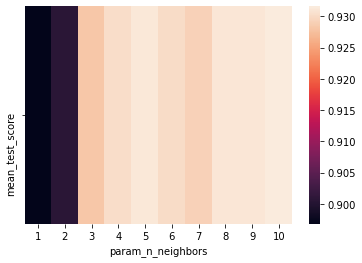

In [17]:
pvt = pd.pivot_table(pd.DataFrame(gs_KNN.cv_results_),
        values='mean_test_score', columns='param_n_neighbors')
sns.heatmap(pvt)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Con el mejor hiperparámetro encontrado, volved a entrenar un clasificador KNN (con _train_) y representar las fronteras de decisión con los puntos de _test_.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Podéis utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.

In [18]:
gs_KNN.best_estimator_.n_neighbors

10

In [19]:
clf_KNN = KNeighborsClassifier(n_neighbors=gs_KNN.best_estimator_.n_neighbors)
clf_KNN.fit(X_train_projection, y_train)

KNeighborsClassifier(n_neighbors=10)

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


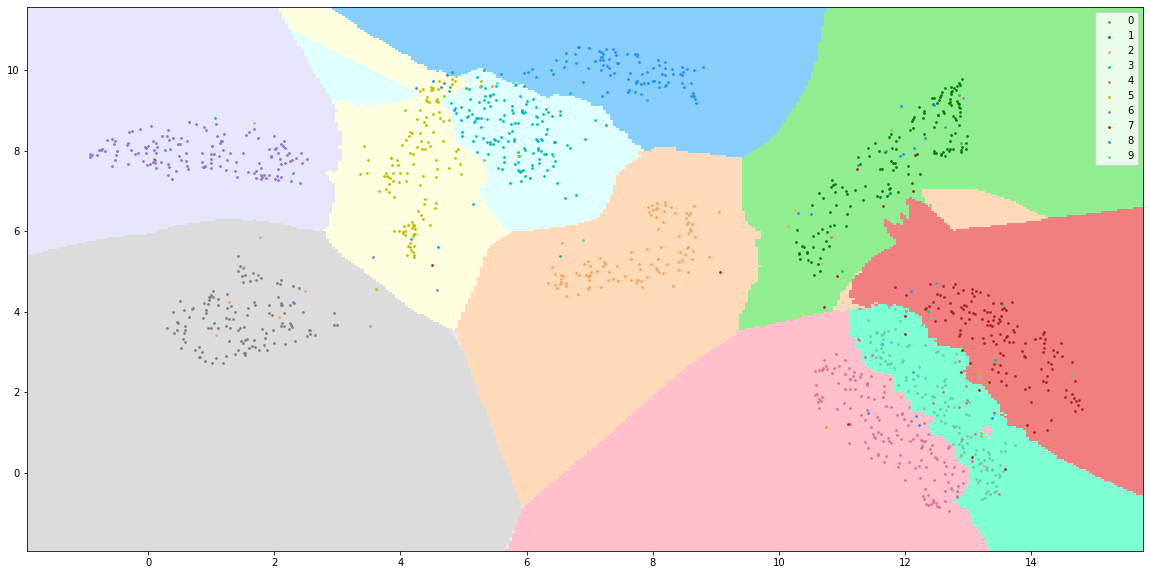

In [20]:
plot_decision_boundaries(clf_KNN, X_test_projection, y_test)

In [21]:
y_pred = clf_KNN.predict(X_test_projection)
accuracy_score(y_test, y_pred)

0.9078571428571428

In [22]:
confusion_matrix(y_test, y_pred)

array([[127,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0, 148,   0,   0,   0,   0,   0,   0,   0,   0],
       [  6,   3, 103,   0,   1,   0,   1,   5,   0,   2],
       [  0,   6,   1, 131,   0,   6,   1,   4,   4,   1],
       [  0,   2,   0,   0, 136,   0,   0,   0,   0,  18],
       [  1,   1,   0,   5,   1, 117,   0,   2,   0,   1],
       [  1,   0,   0,   0,   0,   2, 142,   0,   0,   0],
       [  0,   6,   1,   0,   1,   1,   0, 136,   0,   7],
       [  0,   9,   0,   6,   3,   5,   0,   1,  94,   2],
       [  1,   0,   2,   2,   2,   0,   0,   3,   0, 137]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> 
</div>

Análisis del ejercicio:

   - Comentar los resultados de la búsqueda del mejor hiperparámetro.
   - ¿Cómo se visualiza gráficamente el cambio del valor `n_neighbors`? ¿Tiene sentido esta diferencia entre los dos gráficos al cambiar el parámetro?
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?

### 1.3. SVM

Las Support Vector Machine se fundamentan en el _Máximal Margin Classifier_, que a su vez, se basan en el concepto de hiperplano.

En un espacio p-dimensional, un hiperplano se define como un subespacio plano y afín de dimensiones p-1. El término afín significa que el subespacio no debe pasar por el origen. En un espacio de dos dimensiones, el hiperplano es un subespacio de 1 dimensión, es decir, una recta. En un espacio tridimensional, un hiperplano es un subespacio de dos dimensiones, un plano convencional. Para dimensiones p>3 no es intuitivo visualizar un hiperplano, pero el concepto de subespacio con p-1 dimensiones se mantiene.

La definición de hiperplano para casos perfectamente separables linealmente resulta en un número infinito de posibles hiperplanos, lo que hace necesario un método que permita seleccionar uno de ellos como clasificador óptimo.

La solución a este problema consiste en seleccionar como clasificador óptimo al que se conoce como _maximal margin hyperplane_ o hiperplano óptimo de separación, que se corresponde con el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Para obtenerlo, se debe calcular la distancia perpendicular de cada observación a un determinado hiperplano. La menor de estas distancias (conocida como margen) determina cómo de lejos está el hiperplano de las observaciones de entrenamiento. El _maximal margin hyperplane_ se define como el hiperplano que consigue un mayor margen, es decir, que la distancia mínima entre el hiperplano y las observaciones es lo más grande posible. Aunque esta idea suena razonable, no es posible aplicarla, ya que habría infinitos hiperplanos contra los que medir las distancias. En su lugar, se recurre a métodos de optimización.

El proceso de optimización tiene la peculiaridad de que sólo las observaciones que se encuentran justo al margen o que lo violan influyen sobre el hiperplano. A estas observaciones se les conoce como vectores soporte (_vectors suport_) y son las que definen el clasificador obtenido.

#### Los _kernels_ en SVM

Hay veces en que no hay manera de encontrar un hiperplano que permita separar dos clases. En estos casos decimos que las clases no son linealmente separables. Para resolver este problema podemos utilizar el truco del núcleo .

El truco del núcleo (_kernel trick_) consiste en utilizar una dimensión nueva en la que podamos encontrar un hiperplano para separar las clases. Se puede ver un un ejemplo en: https://www.youtube.com/watch?v=OdlNM96sHio

Al igual que en el algoritmo visto anteriormente (KNN), las SVM también dependen de varios hiperparámetros. 

En este caso intentaremos optimizar dos hiperparámetros:

  - C: es la regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
  
  - gama: coeficiente que multiplica la distancia entre dos puntos en el kernel radial. Para decirlo a "grosso modo", cuanto más pequeño es gama, más influencia tienen dos puntos cercanos. Probaremos los valores: 0.001, 0.01, 0.1, 1 y 10.
  
Al igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (_cross-validation_) con 4 particiones estratificadas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong> 
</div>

Cálcular del valor óptimo de los hiperparámetros _C_ y _gama_. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

Podéis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador SVC (de `SVM` de `sklearn`), y `heatmap` de `Seaborn`.

In [23]:
grid_params = {'C': [0.01, 0.1, 1, 10, 50, 100, 200],
              'gamma':[0.001, 0.01, 0.1, 1 , 10]}

gs_SVM = GridSearchCV(
            SVC(),
            grid_params,
            scoring='accuracy',
            n_jobs=-1,
            cv=4
            )
gs_SVM.fit(X_train_projection, y_train)
gs_SVM.best_estimator_

SVC(C=1, gamma=10)

In [27]:
gs_SVM.cv_results_['mean_test_score']

array([0.11      , 0.59375   , 0.83607143, 0.91875   , 0.11      ,
       0.59214286, 0.88892857, 0.91910714, 0.92857143, 0.93125   ,
       0.88767857, 0.91839286, 0.92589286, 0.93178571, 0.93357143,
       0.91446429, 0.92232143, 0.92875   , 0.93303571, 0.93035714,
       0.92071429, 0.92482143, 0.92946429, 0.9325    , 0.91589286,
       0.92232143, 0.92482143, 0.93035714, 0.93339286, 0.905     ,
       0.92214286, 0.925     , 0.93071429, 0.93357143, 0.89678571])

In [28]:
gs_SVM.cv_results_['std_test_score']

array([0.        , 0.00170346, 0.00469748, 0.00666959, 0.        ,
       0.00220158, 0.00598681, 0.00604775, 0.00772618, 0.00709583,
       0.00653435, 0.00589827, 0.00888382, 0.00778375, 0.00664324,
       0.00637628, 0.00763275, 0.00696886, 0.00627546, 0.00565821,
       0.00931315, 0.00899794, 0.00707783, 0.00598681, 0.00556444,
       0.00879725, 0.00965442, 0.00718736, 0.00763275, 0.00765986,
       0.00843644, 0.00978076, 0.00764319, 0.00726678, 0.0075    ])

In [45]:
pvt = pd.pivot_table(pd.DataFrame(gs_SVM.cv_results_),
    values='mean_test_score', index='param_gamma', columns='param_C')

<AxesSubplot:xlabel='param_C', ylabel='param_gamma'>

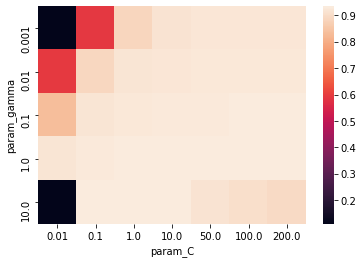

In [46]:
sns.heatmap(pvt)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Con la mejor combinación de hiperparámetros encuentrada, entrenad un clasificador `SVM` (con _train_) y representar las fronteras de decisión con los puntos de _test_.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.

In [52]:
clf_SVM = SVC(C=gs_SVM.best_estimator_.C, gamma=gs_SVM.best_estimator_.gamma)
clf_SVM.fit(X_train_projection, y_train)

SVC(C=1, gamma=10)

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


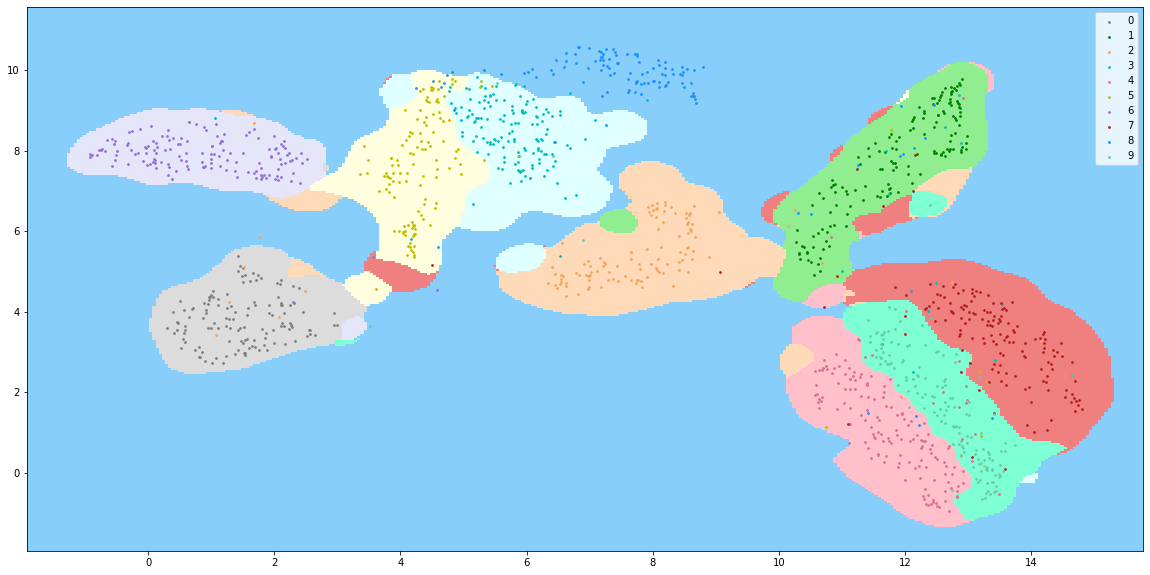

In [53]:
plot_decision_boundaries(clf_SVM, X_test_projection, y_test)

In [54]:
y_pred = clf_SVM.predict(X_test_projection)
accuracy_score(y_test, y_pred)

0.9107142857142857

In [55]:
confusion_matrix(y_test, y_pred)

array([[127,   0,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0, 148,   0,   0,   0,   0,   0,   0,   0,   0],
       [  5,   3, 103,   0,   1,   0,   1,   5,   1,   2],
       [  0,   6,   1, 132,   0,   4,   1,   4,   5,   1],
       [  0,   2,   0,   0, 136,   0,   0,   0,   0,  18],
       [  0,   1,   0,   5,   1, 118,   0,   2,   0,   1],
       [  1,   0,   0,   0,   0,   0, 142,   1,   1,   0],
       [  0,   5,   1,   0,   2,   1,   0, 136,   0,   7],
       [  0,   9,   0,   5,   3,   5,   0,   1,  95,   2],
       [  0,   0,   1,   2,   2,   0,   0,   3,   1, 138]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong>
</div>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?

### 1.4. Árboles de decisión

Los árboles de decisión son modelos predictivos formados por reglas binarias (si / no) con las que se consigue repartir las observaciones en función de sus atributos y predecir así el valor de la variable respuesta.

Los árboles pueden ser **clasificadores** (para clasificar clases, tales como nuestro ejemplo), o bien **regresores** (para predecir variables continuas).

#### Construcción de un árbol

La creación de las ramificaciones de los árboles se logra mediante el algoritmo de *recursive binary splitting*. Este algoritmo consta de tres pasos principales:

   - El proceso se inicia en lo alto del árbol, donde todas las observaciones pertenecen a la misma región.
   - Se identifican todos los posibles puntos de corte para cada uno de los predictores. Los puntos de corte son cada uno de sus niveles.
   - se evalúan las posibles divisiones de cada predictor de acuerdo a una determinada medida. En el caso de los clasificadores se utilizan: *classification error rate*, Gini, entropía, chi-square.

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*. 

Para prevenirlo, utilizaremos dos hiperparámetros:

   - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10.
   - `min_samples_split`: el número mínimo de observaciones que debe tener una hoja del árbol para poder dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
</div>

Calculad el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split`. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
Pódeis utilizar el módulo `GridSearchCV` de `sklearn` el cálculo de los mejores hiperparámetros con el clasificador `DecisionTreeClassifier` (de `tree` de `sklearn`), y `heatmap` de `Seaborn`.

In [56]:
grid_params = {'max_depth':[4, 10],
              'min_samples_split':[2, 10, 20, 50, 100]}

gs_DecisionTree = GridSearchCV(
                    DecisionTreeClassifier(),
                    grid_params,
                    scoring='accuracy',
                    n_jobs=-1,
                    cv=4
                    )
gs_DecisionTree.fit(X_train_projection, y_train)
gs_DecisionTree.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_split=20)

In [57]:
gs_DecisionTree.cv_results_['mean_test_score']

array([0.79375   , 0.79339286, 0.79339286, 0.79339286, 0.79339286,
       0.90785714, 0.90892857, 0.915     , 0.90892857, 0.90214286])

In [58]:
gs_DecisionTree.cv_results_['std_test_score']

array([0.01687571, 0.01723469, 0.01723469, 0.01723469, 0.01723469,
       0.00387956, 0.00358924, 0.00608192, 0.00469748, 0.00679511])

In [67]:
pvt = pd.pivot_table(pd.DataFrame(gs_DecisionTree.cv_results_),
    values='mean_test_score', index='param_min_samples_split', columns='param_max_depth')

<AxesSubplot:xlabel='param_max_depth', ylabel='param_min_samples_split'>

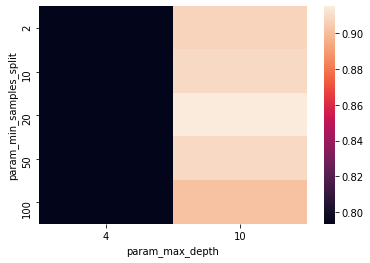

In [69]:
sns.heatmap(pvt)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Con la mejor combinación de hiperparámetros encontrados, entrenad un clasificador `DecisionTreeClassifier` (con `train`) y representar las fronteras de decisión con los puntos de `test`.
    
Calcular el _accuracy_ del modelo obtenido sobre _test_ y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.

In [72]:
gs_DecisionTree.best_estimator_.min_samples_split

20

In [73]:
clf_DecisionTree = DecisionTreeClassifier(max_depth=gs_DecisionTree.best_estimator_.max_depth, 
                                          min_samples_split=gs_DecisionTree.best_estimator_.min_samples_split)
clf_DecisionTree.fit(X_train_projection, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=20)

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


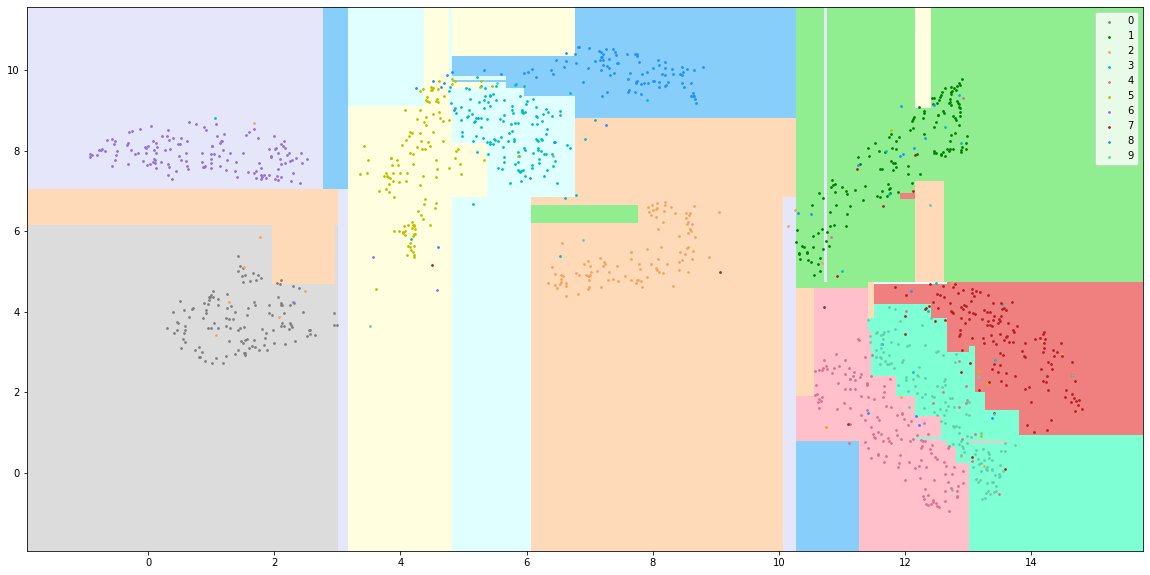

In [74]:
plot_decision_boundaries(clf_DecisionTree, X_test_projection, y_test)

In [75]:
y_pred = clf_DecisionTree.predict(X_test_projection)
accuracy_score(y_test, y_pred)

0.8942857142857142

In [76]:
confusion_matrix(y_test, y_pred)

array([[125,   0,   2,   0,   0,   0,   2,   0,   0,   0],
       [  0, 144,   0,   0,   2,   1,   0,   1,   0,   0],
       [  6,   2, 103,   0,   0,   0,   2,   5,   0,   3],
       [  0,   6,   5, 129,   0,   4,   1,   2,   5,   2],
       [  0,   2,   0,   0, 138,   0,   0,   0,   1,  15],
       [  1,   1,   0,   7,   1, 114,   0,   2,   1,   1],
       [  1,   0,   0,   0,   0,   2, 142,   0,   0,   0],
       [  0,   5,   2,   0,   2,   1,   0, 130,   0,  12],
       [  0,   9,   1,   6,   2,   5,   0,   1,  93,   3],
       [  0,   0,   2,   2,   5,   1,   0,   3,   0, 134]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong>
</div>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?

### 1.5. Mejorando los árboles de decisión

En la práctica, casi nunca se utiliza un solo árbol de decisión, sino que se combinan muchos árboles para obtener mejores resultados. Hay dos maneras de combinar árboles:

  - *__Bagging__*: utilizar el conjunto de entrenamiento original para generar centenar o miles de conjuntos similares utilizando muestreo con reemplazo. El algoritmo _random forest_ está basado en este concepto, la combinación de varios árboles de decisión, cada uno entrenado con una muestra diferente de los datos. La decisión final del clasificador combinado (la _random forest_) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).
  
  - *__Boosting__*: se combinan varios clasificadores débiles secuencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificadas en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.
  
Ambos métodos los estudiaremos más en detalle en la próxima PEC, pero en esta haremos un vistazo a los beneficios que nos aporta utilizar combinaciones de árboles respecto un solo árbol.

Al tratarse de árboles, sigue siendo importante optimizar `max_depth` y `min_samples_split`, pero en este caso añadiremos un hiperparámetro más. Para simplificar, de los dos parámetros anteriores optimizaremos sólo `max_depth`:

  - `n_estimators`: número de árboles. Exploraremos los valores: 50, 100 y 200.
  - `max_depth`: la profundidad máxima del árbol. Exploraremos los valores entre 8 y 12.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
</div>

Escoged uno de los dos algoritmos mencionados: RandomForestClassifier o GradientBoostingClassifier. Calculad el valor óptimo de los hiperparámetros `n_estimators` y `max_depth`. Utilizad una búsqueda de rejilla con validación cruzada para encontrar los valores óptimos. Para cada combinación de valores, calcular su promedio y la desviación estándar. Haced un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.
    
Podéis utilizar el módulo `GridSearchCV` de `sklearn` para el cálculo de los mejores hiperparámetros con el clasificador `RandomForestClassifier` o `GradientBoostingClassifier` (de `ensemble` de `sklearn`), y `heatmap` de `Seaborn`.
    
<u>Nota</u>: al utilizar tantos árboles, el _cross validation_ con todas las combinaciones de parámetros es más costosa que en los ejemplos anteriores, y por lo tanto tardará más en ejecutarse.

In [79]:
grid_params = {'max_depth':[8, 12],
              'n_estimators':[50, 100, 200]}
gs_GBoostingCl = GridSearchCV(
                GradientBoostingClassifier(),
                grid_params,
                scoring='accuracy',
                n_jobs=-1,
                cv=4
                )
gs_GBoostingCl.fit(X_train_projection, y_train)
gs_GBoostingCl.best_estimator_

GradientBoostingClassifier(max_depth=8, n_estimators=200)

In [80]:
gs_GBoostingCl.cv_results_['mean_test_score']

array([0.9175    , 0.91678571, 0.91821429, 0.90553571, 0.91303571,
       0.91482143])

In [81]:
gs_GBoostingCl.cv_results_['std_test_score']

array([0.0056807 , 0.00602927, 0.00309295, 0.00665044, 0.0041149 ,
       0.00429686])

In [82]:
pvt = pd.pivot_table(pd.DataFrame(gs_GBoostingCl.cv_results_),
    values='mean_test_score', index='param_n_estimators', columns='param_max_depth')

<AxesSubplot:xlabel='param_max_depth', ylabel='param_n_estimators'>

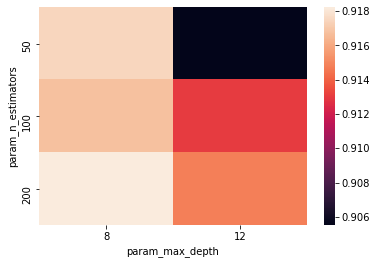

In [83]:
sns.heatmap(pvt)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Con la mejor combinación de hiperparámetros encontrada, entrenad un clasificador `DecisionTreeClassifier` (con _train_) y representar las fronteras de decisión con los puntos de test.
    
Calcular el _accuracy_ del modelo obtenido sobre test y la matriz de confusión. Puede utilizar `accuracy_score` y `confusion_matrix` de `metrics` de `sklearn`.

In [84]:
clf_GBoosting = GradientBoostingClassifier(max_depth=gs_GBoostingCl.best_estimator_.max_depth,
                                          n_estimators=gs_GBoostingCl.best_estimator_.n_estimators)
clf_GBoosting.fit(X_train_projection, y_train)

GradientBoostingClassifier(max_depth=8, n_estimators=200)

<ipython-input-7-53494ca68afb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


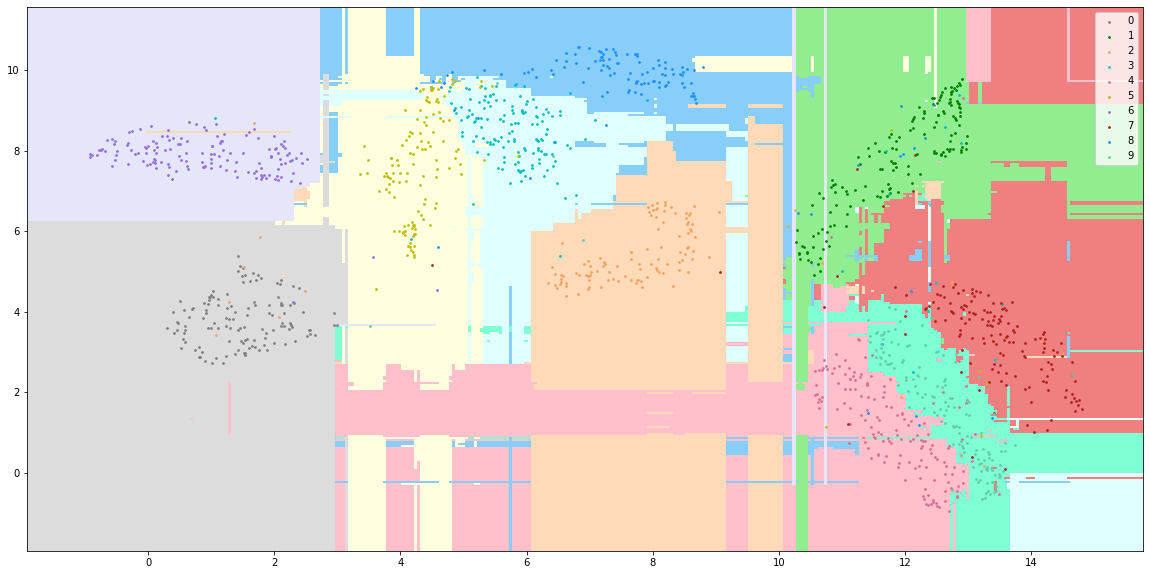

In [85]:
plot_decision_boundaries(clf_GBoosting, X_test_projection, y_test)

In [86]:
y_pred = clf_GBoosting.predict(X_test_projection)
accuracy_score(y_test, y_pred)

0.8957142857142857

In [87]:
confusion_matrix(y_test, y_pred)

array([[123,   0,   2,   0,   0,   0,   4,   0,   0,   0],
       [  0, 146,   1,   0,   0,   0,   0,   0,   1,   0],
       [  6,   2, 103,   0,   1,   0,   1,   5,   1,   2],
       [  0,   6,   1, 130,   0,   5,   1,   4,   6,   1],
       [  0,   1,   0,   0, 138,   0,   0,   1,   1,  15],
       [  0,   1,   0,   9,   2, 110,   0,   2,   4,   0],
       [  1,   0,   0,   0,   0,   2, 142,   0,   0,   0],
       [  0,   5,   1,   0,   2,   1,   0, 134,   0,   9],
       [  0,   9,   0,   5,   2,   6,   0,   1,  94,   3],
       [  0,   0,   1,   3,   3,   0,   1,   4,   1, 134]])

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong>
</div>

Análisis del ejercicio.

   - Comentar los resultados de la búsqueda de los mejores hiperparámetros.
   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
   - ¿Ha habido mejora respecto a utilizar un simple árbol de decisión?

# 2. Implementación del caso práctico (5 puntos)

Para este ejercicio se proporciona un _dataset_ con datos sobre diferentes clientes de un banco que quieren comprar un piso, y si el banco les ha concedido la hipoteca o no. 

La información es la siguiente:

  - `ingresos`: los ingresos mensuales de la familia.
  - `gastos_comunes`: pagos mensuales de luz, agua, gas, etc.
  - `pago_coche`: si se está pagando cuota por uno o más coches, y los gastos mensuales en combustible, etc.
  - `gastos_otros`: compra mensual en supermercado y lo necesario para vivir.
  - `ahorros`: suma de ahorros dispuestos a utilizar para la compra de la casa.
  - `vivienda`: precio de la vivienda que quiere comprar esta familia.
  - `estado_civil`: 0-soltero, 1-casados, 2-divorciados
  - `hijos`: cantidad de hijos menores y que no trabajan.
  - `trabajo`: 0-sin empleo, 1-autónomo (freelance), 2-empleado, 3-empresario, 4-pareja: autónomos, 5-pareja: empleados, 6-pareja: autónomo y asalariado, 7-pareja: empresario y autónomo , 8-pareja: empresarios los dos o empresario y empleado
  - `hipoteca`: 0-No ha sido concedida, 1-Si que ha sido concedida (esta será nuestra columna de salida, para aprender)
  
Empezamos leyendo el _dataset_ y viendo una muestra de las primeras filas.

In [28]:
hipotecas = pd.read_csv("hipotecas.csv")
hipotecas.head(10)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,hipoteca
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


### 2.1. Análisis descriptivo

Cuando se nos proporciona un _dataset_, antes de empezar a hacer nada, es muy importante hacer un análisis exploratorio para conocer los datos con los que trabajaremos.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> 
</div>

Calculad las frecuencias de la variable _target_ (`hipoteca`). Analizar la distribución de las otras variables con gráficos de barras las variables categóricas y con histogramas las variables numéricas.

In [19]:
gs_KNN.best_estimator_.metric

'minkowski'

### 2.2. Preprocesamiento de los datos

Una vez hecho un primer análisis, se trata de "limpiar" el dataset y adaptarlo a nuestras necesidades (en este caso, predecir si se concederá la hipoteca o no).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Comprueba si hay valores `null`. En caso de haberlos, elimina las filas correspondientes.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong> 
</div>

- Agrupad los diversos gastos mensuales (`pago_coche` + `gastos_comunes` + `gastos_otros`) en una variable llamada `gastos`.
- Calculad el montante a financiar en una variable llamada `financiar`. Para ello crea una columna llamada `financiar` que será el resto del precio de la vivienda con los ahorros de la familia.
- Elimina las variables utilizadas para crear estas nuevas columnas.

El siguiente paso sería ver la correlación entre todas las _features_ numéricas. Esto se hace para asegurar que no hay dos variables muy relacionadas entre sí, ya que en tal caso se debería seleccionar una de las dos o combinarlas en una nueva.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Mostrad la correlación entre todas las _features_ numéricas. Si hay dos con una correlación superior al 80%, eliminar una de las dos.
    
Podéis utilizar `heatmap` de `Seaborn`, para verlas en un mapa de colores.

Ya tenemos las variables finales con las que trabajaremos. Vamos a observar ahora cuál es la relación de cada una de ellas con el `target`.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Repite los diagramas de barras y los histogramas, separando por colores la variable _target_ (dentro del mismo gráfico, diferenciar entre hipoteca-sí y hipoteca-no).
    
<u>Nota</u>: Puedes utilizar el parámetro `alpha` para que se vean los dos gráficos a la vez.

Finalmente, sólo nos queda pasar las variables categóricas a numéricas. Observad que a pesar de que todas las variables tengan números, esto no quiere decir que sean numéricas. Por ejemplo, la variable `estado_civil` tiene los valores 0-1-2, que sería lo mismo que si tuviera los valores soltero-casado-divorciado. Hay otras variables donde esto no ocurre, por ejemplo el número de hijos, que a pesar de ser categórica sí que son números, ya que es ordinal. La manera de diferenciarlo es, en el caso del número de hijos, 1 hijo es menos que 2 hijos, mientras que con el estado civil no hay un orden.

Una manera de pasar las variables categóricas en numéricas es aplicando _one-hot encoding_. Por ejemplo, en el caso de la variable `estado_civil`, lo que se haría sería crear tres columnas nuevas: `soltero`, `casado` y `divorciado`. Estas columnas tendrían los valores 0-1, por ejemplo, en el caso de la columna `soltero` tendría el valor 1 cuando `estado_civil = soltero`, y cero en otro caso.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Aplica _one-hot-encoding_ a las variables categóricas que lo requieran. No olvidéis eliminar las variables originales!
    
Podéis utilizar `OneHotEncoder` de `sklearn.preprocessing`.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong>
</div>

- ¿Por qué es necesario hacer _one-hot encoding_? 
- ¿Qué diferencia hay entre tener una columna `estado_civil` o tres columnas `soltero`, `casado` y `divorciado` si la información es la misma? 
- ¿Por qué es incorrecto a nivel conceptual dejar las variables tal y como las teníamos, si eran números y el modelo hubiera funcionado?


### 2.3. Entrenamiento de un modelo

Ahora que ya tenemos el _dataset_ limpio y hemos hecho un análisis de las diferentes variables, podemos proceder a entrenar un modelo para predecir si se concede una hipoteca o no. 

Probaremos con 2 modelos diferentes e interpretaremos los resultados. 

Para empezar, separamos el dataset entre _train_ y _test_.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong> 
</div>

Dividid el _dataset_ en dos subconjuntos: _train_ (80% de los datos) y _test_ (20% de los datos). Nombrad los conjuntos: X_train, X_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Utilizad un árbol de decisión simple con `max_depth = 5` para acotar el dataset "hipotecas" sobre el conjunto de _train_. Dibujad el árbol de decisión. Calculad el _accuray_ y la matriz de confusión sobre _train_ y sobre _test_.
    
Para dibujar el árbol, podéis guiaros con este enlace: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> 
</div>

Interpretad el árbol de decisión:

- ¿Cuáles son las variables que han tenido más peso? 
- ¿Has obtenido una buena precisión evaluando en test? 
- ¿Se ha producido _overfitting_?

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Usad _Random Forest_ o _Gradient Boosting_ para acotar el _dataset_ "hipotecas". Esta vez vamos a optimizar el modelo para obtener los mejores resultados posibles. Tal y como hemos visto en el ejercicio anterior, recuerda seguir los siguientes pasos:
    
   - Utilizar el _dataset_ de _train_ para encontrar los mejores hiperparámetros haciendo _cross-validation_.
   - Entrenar el modelo con _train_, predecir con test y calcular su _accuracy_ y la matriz de confusión.

Un _Random Forest_ / _Gradient Boosting_ no es tan fácil de interpretar como un simple _Decision Tree_. No podemos dibujar el árbol, porque son combinaciones de muchos árboles, pero si que podemos saber cuáles han sido las variables más decisivas a la hora de generar el modelo. Para saberlo, no podemos hacerlo a ojo mirando cómo se divide el árbol, sino que lo podemos consultar al modelo mediante la _feature importance_ de este.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Muestra cada variable del modelo fitado, junto con su _feature importance_.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> 
</div>

Interpreta el clasificador:

- ¿Cuáles son las variables que han tenido más peso? 
- ¿Has obtenido una buena precisión evaluando en test? 
- ¿Se ha producido _overfitting_?

### 2.4. Predicción de nuevos casos

Hasta ahora hemos entrenado un modelo y hemos evaluado en test para hacernos una idea de la precisión de nuestro modelo con datos reales. Ahora vamos a utilizarlo.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
</div>

Suponed que trabajáis en un banco y os visitan clientes que quieren una hipoteca. Aunque se ha de realizar un estudio a fondo de cada caso, así _a priori_ utilizad el clasificador entrenado para tener una idea de si se les concederá la hipoteca o no.
    
   - Caso 1: Familia con unos ingresos de 2.000 € y unos gastos de 500 €, la pareja son empresarios y no tienen hijos. Necesitarían para tener la casa de sus sueños una financiación de 200.000 €.
   - Caso 2: Familia con unos ingresos de 6.000 € y unos gastos de 3.400 €, la pareja uno es asalariado y el otro autónomo con dos hijos a su cargo. Necesitarían para tener la casa de sus sueños una financiación de 320.000 €.
   - Caso 3: Una mujer soltera con unos ingresos de 9.000 € y unos gastos de 2.250 €, con un hijo a su cargo y de profesión autónoma. Necesitaría una financiación de 39.000 €.